In [14]:
import os
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import pickle
import pickle
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from tqdm import tqdm
import cv2

In [4]:

#getting image data
train_img={}
img_id=[]
img_array=[]
for files in os.listdir('stage1_train'):
    path = 'stage1_train/'+ files + '/images/' + files +'.png'
    im = Image.open(path)
    im= np.asarray(im)
    train_img[files+'.png'] = im
    img_id.append(files+'.png')
    img_array.append(im)  

670

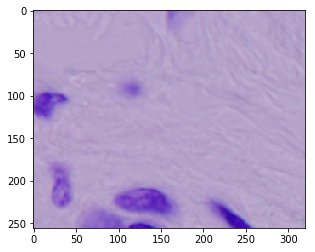

In [5]:
plt.imshow(img_array[4])
len(img_array)

In [6]:
#getting masks

train_mask_dict={}
mask_array=[]
for files in os.listdir('stage1_train'):
    arr=0
    for file in os.listdir('stage1_train/'+files+'/masks/'):
        path = 'stage1_train/'+ files + '/masks/' + file
        im1=Image.open(path)
        im1= np.asarray(im1)
        mask = cv2.resize(im1, (256,256))
        arr = arr + mask
        
    train_mask_dict[files+'.png'] = arr
    mask_array.append(arr)


670

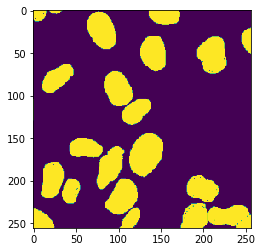

In [7]:
plt.imshow(mask_array[7])
mask_array[9].shape
len(mask_array)

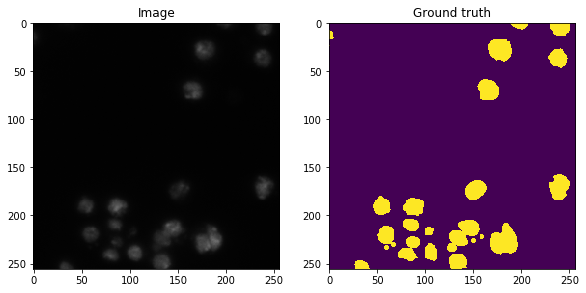

In [8]:
#Plotting some examples with their ground truth
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(img_array[0])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask_array[0])
plt.title('Ground truth')
plt.show()


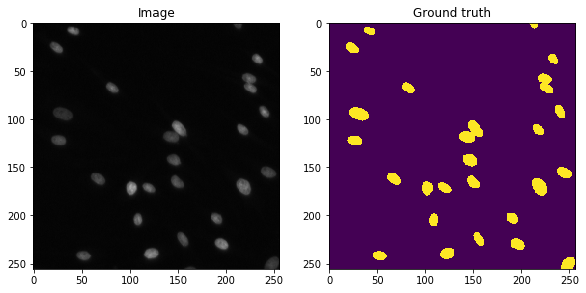

In [9]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(img_array[77])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask_array[77])
plt.title('Ground truth')
plt.show()


In [10]:
def preprocessing(img,mask,SIZE):
    img = img[:,:,:3]
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
   
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img,mask)

In [11]:
input_img=[]
output_mask=[]
for i,k in tqdm(zip(img_array,mask_array)):
    processed=preprocessing(i,k,(256,256))
    input_img.append(processed[0])
    output_mask.append(processed[1])

670it [00:01, 386.14it/s]


In [12]:
input_img[0].shape

(256, 256, 3)

In [13]:
output_mask[0].shape

(256, 256, 1)

In [14]:
input_img=np.asarray(input_img)
output_mask=np.asarray(output_mask)

In [15]:
train_img, val_img= input_img[:550], input_img[550:]
train_mask, val_mask = output_mask[:550], output_mask[550:]

In [16]:
test_img={}
test_img_id=[]
test_img_array=[]
for files in os.listdir('stage1_test'):
    path = 'stage1_test/'+ files + '/images/' + files +'.png'
    im = Image.open(path)
    im= np.asarray(im)
    test_img[files+'.png'] = im
    test_img_id.append(files+'.png')
    test_img_array.append(im)  

In [17]:
test_img_array[0].shape

(256, 256, 4)

In [18]:
def preprocessing_test(img,SIZE):
    img = img[:,:,:3]
    img = cv2.resize(img, SIZE)
   
    img = img/255.
    return img

In [19]:
test_input=[]
for i in tqdm(test_img_array):
    processed=preprocessing_test(i,(256,256))
    test_input.append(processed)

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 447.40it/s]


In [20]:
test_input=np.asarray(test_input)

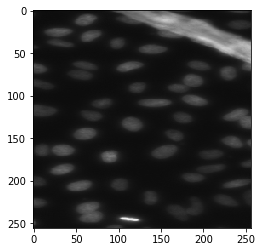

In [31]:
plt.imshow(test_input[1])

In [7]:
import model.u_net as unet

In [8]:
model = unet.get_unet(num_classes=1)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 256, 256, 32) 0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 32) 9248        activation_55[0][0]              
__________________________________________________________________________________________________
activation

In [10]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

In [11]:
# fit model
model.fit(train_img, train_mask, epochs=100, verbose=2, callbacks=callbacks, validation_data=(val_img,val_mask), batch_size=1)

Train on 550 samples, validate on 120 samples
Epoch 1/100
 - 374s - loss: 0.9270 - dice_coeff: 0.4209 - val_loss: 0.5207 - val_dice_coeff: 0.7214
Epoch 2/100
 - 361s - loss: 0.3743 - dice_coeff: 0.7797 - val_loss: 0.2284 - val_dice_coeff: 0.8679
Epoch 3/100
 - 360s - loss: 0.2873 - dice_coeff: 0.8275 - val_loss: 0.2093 - val_dice_coeff: 0.8691
Epoch 4/100
 - 360s - loss: 0.2570 - dice_coeff: 0.8458 - val_loss: 0.2169 - val_dice_coeff: 0.8795
Epoch 5/100
 - 360s - loss: 0.2425 - dice_coeff: 0.8552 - val_loss: 0.1891 - val_dice_coeff: 0.8850
Epoch 6/100
 - 360s - loss: 0.2619 - dice_coeff: 0.8579 - val_loss: 0.1904 - val_dice_coeff: 0.8985
Epoch 7/100
 - 360s - loss: 0.2209 - dice_coeff: 0.8693 - val_loss: 0.2588 - val_dice_coeff: 0.8626
Epoch 8/100
 - 360s - loss: 0.2144 - dice_coeff: 0.8730 - val_loss: 0.1768 - val_dice_coeff: 0.8955
Epoch 9/100
 - 360s - loss: 0.2083 - dice_coeff: 0.8754 - val_loss: 0.1761 - val_dice_coeff: 0.9046
Epoch 10/100
 - 360s - loss: 0.2015 - dice_coeff: 0.88

In [12]:
model.save_weights('nuclei_segmentation_weights.h5')

In [10]:
model.load_weights('nuclei_segmentation_weights.h5')

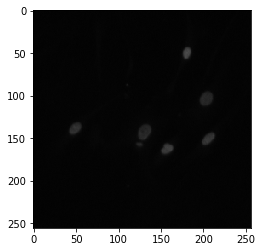

In [32]:
plt.imshow(test_input[0])

In [33]:
#Now making predictions
pred=model.predict(test_input[0].reshape(-1,256,256,3))

In [35]:
pred.shape

(1, 256, 256, 1)

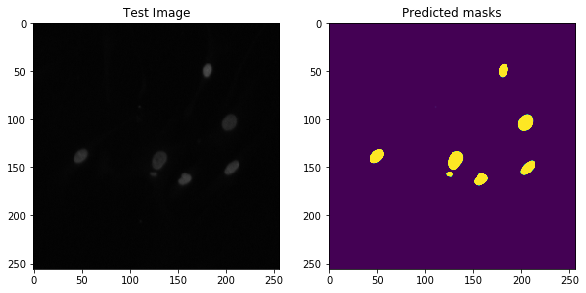

In [37]:
#Results
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[0])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()


In [39]:
pred=model.predict(test_input[1].reshape(-1,256,256,3))

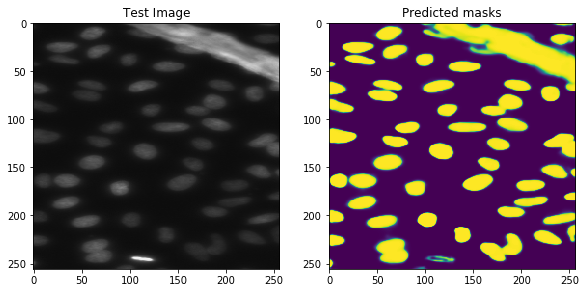

In [40]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[1])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()


In [42]:
pred=model.predict(test_input[7].reshape(-1,256,256,3))

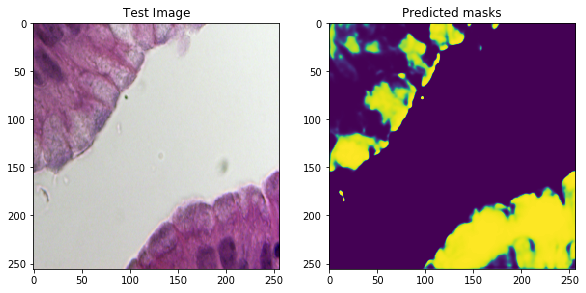

In [43]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[7])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()


In [44]:
pred=model.predict(test_input[4].reshape(-1,256,256,3))

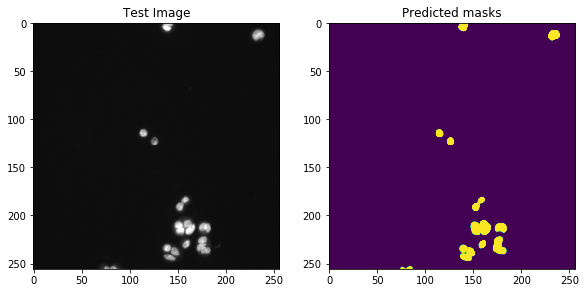

In [45]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[4])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()

In [21]:
pred=model.predict(test_input[19].reshape(-1,256,256,3))

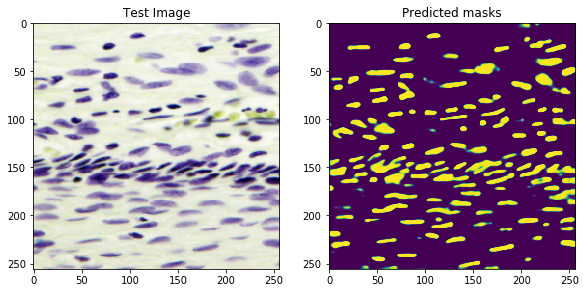

In [22]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[19])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()